In [1]:
import pandas as pd
import numpy as np
import rasterio
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator

2023-04-11 03:52:10.398430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from keras.applications import ResNet50

In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.3, 1.3]
)

In [6]:
labels = []

for file in os.listdir("tiff_images/"):
    labels.append(int(file.split("_")[-2]))

In [7]:
overview = pd.read_csv("overview.csv")

In [8]:
X = []
#collecting the file name and reading the image files using rasterio
for path in overview["tiff_name"]:
    with rasterio.open(f"tiff_images/{path}") as img:
        arr = img.read()
        arr = arr.reshape((512, 512, 1))
        arr = np.array(arr) / 255
        X.append(arr)

X = np.array(X)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [9]:
X = np.array([x.repeat(3, axis = -1) for x in X])

In [10]:
X.shape

(100, 512, 512, 3)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(labels), test_size=0.2, random_state=42)

In [12]:
X_train.shape

(80, 512, 512, 3)

In [13]:
model = Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2023-04-11 03:52:53.066497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,702,593
Trainable params: 24,649,473
Non-trainable params: 53,120
_________________________________________________________________


In [15]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
reshist = model.fit(
    datagen.flow(X_train, y_train, batch_size = 12),
    validation_data=(X_test, y_test),
    epochs = 100
)

Epoch 1/10


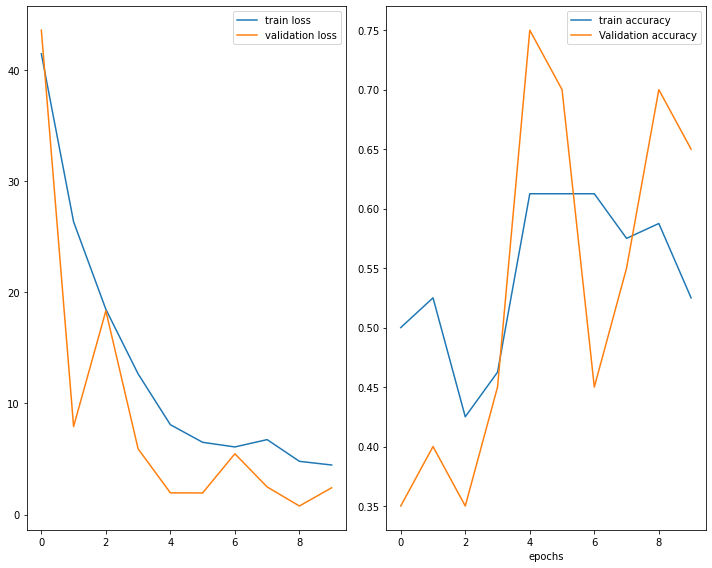

In [ ]:
fig = plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
plt.plot(list(range(100)), reshist.history['loss'], label="train loss")
plt.plot(list(range(100)), reshist.history['val_loss'], label="validation loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(list(range(100)), reshist.history["accuracy"], label="train accuracy")
plt.plot(list(range(100)), reshist.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("epochs")
plt.legend()
plt.tight_layout()